# Chapter 6: Finetuning for Text Classification

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",  # Plotting library
        "numpy",       # PyTorch & TensorFlow dependency
        "tiktoken",    # Tokenizer
        "torch",       # Deep learning library
        "tensorflow",  # For OpenAI's pretrained weights
        "pandas"       # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.7
numpy version: 2.3.3
tiktoken version: 0.12.0
torch version: 2.9.0+cu126
tensorflow version: 2.20.0
pandas version: 2.3.3


In [2]:
import pandas as pd

train_df = pd.read_parquet("../clean_dataset/train_clean.parquet")[["summary", "nominated"]].rename(columns={"summary": "Text", "nominated": "Label"})
test_df = pd.read_parquet("../clean_dataset/test_clean.parquet")[["summary", "nominated"]].rename(columns={"summary": "Text", "nominated": "Label"})
val_df = pd.read_parquet("../clean_dataset/val_clean.parquet")[["summary", "nominated"]].rename(columns={"summary": "Text", "nominated": "Label"})

In [3]:
train_df.head()

,Text,Label
0,"Sergeant Nico Toscani, a native of Palermo, Si...",0
1,"Theodore ""Ted"" Crawford (Anthony Hopkins), a w...",0
2,"In 2017, New York Times reporter Jodi Kantor r...",0
3,During an April 1943 bombing mission against t...,0
4,Sherman McCoy is a Wall Street bond trader who...,0


In [4]:

train_df.to_csv("train.csv", index=None)
test_df.to_csv("test.csv", index=None)
val_df.to_csv("validation.csv", index=None)

In [5]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [6]:
import torch
from torch.utils.data import Dataset


class MovieDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            # self.encoded_texts = [
            #     encoded_text[:self.max_length]
            #     for encoded_text in self.encoded_texts
            # ]
            self.encoded_texts = [
                encoded_text[-self.max_length:]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
        # Note: A more pythonic version to implement this method
        # is the following, which is also used in the next chapter:
        # return max(len(encoded_text) for encoded_text in self.encoded_texts)

In [7]:
train_dataset = MovieDataset(
    csv_file="train.csv",
    max_length=1024,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

1024


In [8]:
train_dataset[0][0].shape

torch.Size([1024])

In [9]:
val_dataset = MovieDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = MovieDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [10]:
from torch.utils.data import DataLoader
torch.manual_seed(123)


num_workers = 0
batch_size = 8


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [11]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 1024])
Label batch dimensions torch.Size([8])


In [12]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

165 training batches
55 validation batches
55 test batches


In [13]:
import torch
import torch.nn as nn

class OscarPredictor(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_encoder_layers=4, num_decoder_layers=2):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, 1024, d_model))  # positional embedding
        
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True),
            num_layers=num_encoder_layers,
        )
        
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True),
            num_layers=num_decoder_layers,
        )
        
        # A learnable query for the decoder to attend to the encoder outputs
        self.query = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Final classifier
        self.fc = nn.Linear(d_model, 1)
        
    def forward(self, input_ids, attention_mask=None):
        # input_ids: [B, T]
        x = self.token_emb(input_ids) + self.pos_emb[:, :input_ids.size(1), :]
        memory = self.encoder(x, src_key_padding_mask=(attention_mask == 0) if attention_mask is not None else None)
        
        # Use the same query for all batches
        query = self.query.expand(input_ids.size(0), -1, -1)
        
        # The decoder attends to the encoder memory
        out = self.decoder(query, memory)
        
        # Predict a single probability
        logits = self.fc(out.squeeze(1))  # shape [B, 1]
        # prob = torch.sigmoid(logits)
        return logits


In [14]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

# assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
#     f"Dataset length {train_dataset.max_length} exceeds model's context "
#     f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
#     f"`max_length={BASE_CONFIG['context_length']}`"
# )

In [15]:
model = OscarPredictor(vocab_size=BASE_CONFIG['vocab_size'])

In [19]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [20]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

# device = torch.device("cpu")

print("Device:", device)

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Device: cuda
Training accuracy: 83.75%
Validation accuracy: 82.50%
Test accuracy: 80.00%


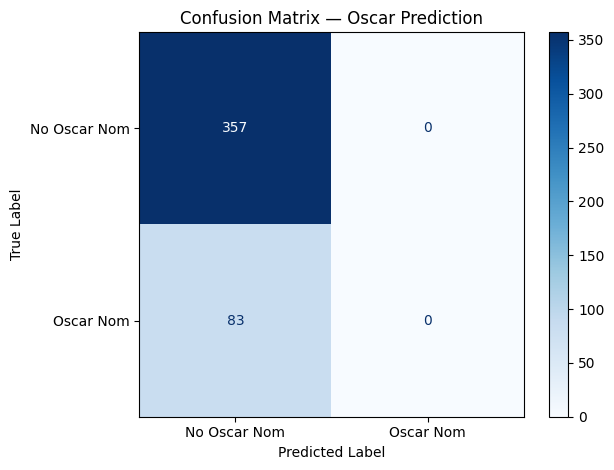

Accuracy: 0.811


In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming:
#   - model: your trained OscarPredictor
#   - test_loader: a DataLoader yielding (input_ids, attention_mask, labels)

def evaluate_and_plot_confusion(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, labels = batch

            input_ids = input_ids.to(device)

            probs = model(input_ids)
            preds = (probs > 0.5).long().cpu().numpy()   # threshold at 0.5

            all_preds.extend(preds.flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Oscar Nom", "Oscar Nom"])
    disp.plot(cmap=plt.cm.Blues, values_format='d')

    plt.title("Confusion Matrix — Oscar Prediction")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Optional: return metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Accuracy: {accuracy:.3f}")

    return cm, accuracy


# Example usage
cm, acc = evaluate_and_plot_confusion(model, test_loader)

In [23]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

The `calc_loss_loader` is exactly the same as in chapter 5

In [ ]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- Using the `calc_closs_loader`, we compute the initial training, validation, and test set losses before we start training

In [ ]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

In [ ]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [ ]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In [ ]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

- Finally, let's use the finetuned GPT model in action
- The `classify_review` function below implements the data preprocessing steps similar to the `SpamDataset` we implemented earlier
- Then, the function returns the predicted integer class label from the model and returns the corresponding class name

In [ ]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length must be specified. If you want to use the full model context, "
        "pass max_length=model.pos_emb.weight.shape[0]."
    )
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) exceeds model's supported context length ({supported_context_length})."
    )    
    # Alternatively, a more robust version is the following one, which handles the max_length=None case better
    # max_len = min(max_length,supported_context_length) if max_length else supported_context_length
    # input_ids = input_ids[:max_len]
    
    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

- Let's try it out on a few examples below

In [ ]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

In [ ]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

- Finally, let's save the model in case we want to reuse the model later without having to train it again

In [ ]:
torch.save(model.state_dict(), "review_classifier.pth")

- Then, in a new session, we could load the model as follows

In [ ]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

## Summary and takeaways

- See the [./gpt_class_finetune.py](./gpt_class_finetune.py) script, a self-contained script for classification finetuning
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)
- In addition, interested readers can find an introduction to parameter-efficient training with low-rank adaptation (LoRA) in [appendix E](../../appendix-E)